In [88]:
from sklearn.metrics import precision_recall_fscore_support, ConfusionMatrixDisplay
import pandas as pd
import numpy as np
import plotly.express as px
import yfinance as yf
from tqdm import tqdm
import pandas_ta as ta
import plotly.graph_objects as go
import lightgbm as lgb
import featuretools as ft
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [89]:
from funcoes import *
from backtesting import *

# Carregando base

In [106]:
# treino e validacao
# Carregando base
df = pd.read_parquet('base/base_desenvolvimento.parquet.gzip')
df['acao'] = df['acao'].astype('category')

In [103]:
df.dropna(inplace=True)

# Divisão treino e teste
- Treino: 2015 - 2022
- Teste: 2023
- Val: 2024

In [104]:
df_train = df.loc[(df['Date'] >= '2015-06-01') & (df['Date'] <= '2022-12-31')]
df_test = df.loc[(df['Date'] >= '2023-01-01') & (df['Date'] <= '2023-12-31')]
df_val = df.loc[df['Date'] > '2023-12-31']

In [109]:
df.head()

,index,Date,Open,High,Low,Close,Volume,acao,CDL_DOJI_10_0.1,CDL_INSIDE,...,PVR,PVT,signal,label_l1,label_l2,label_l3,mes,dia_semana,dia_mes,dia_ano
66,66,2015-09-03,3.584188,3.677653,3.584188,3.657335,578716.0,ABCB4,0.0,1,...,2.0,-5.004056e+06,0,1.0,0.0,0.0,9,3,3,246
67,67,2015-09-04,3.693908,3.693908,3.506978,3.511041,142967.0,ABCB4,0.0,0,...,4.0,-5.575924e+06,1,0.0,0.0,0.0,9,4,4,247
68,68,2015-09-08,3.551678,3.632952,3.478531,3.515105,318556.0,ABCB4,0.0,0,...,1.0,-5.539055e+06,0,0.0,0.0,0.0,9,1,8,251
69,69,2015-09-09,3.584188,3.628889,3.527296,3.584188,241635.0,ABCB4,100.0,1,...,2.0,-5.064162e+06,0,0.0,0.0,0.0,9,2,9,252
70,70,2015-09-10,3.527296,3.527296,3.433831,3.515105,229687.0,ABCB4,100.0,0,...,4.0,-5.506872e+06,0,0.0,0.0,0.0,9,3,10,253


# Seleção de features

In [111]:
features = [
    'Open', 'High', 'Low', 'Close', 'Volume', 'acao', 'CDL_DOJI_10_0.1', 'CDL_INSIDE', 'open_Z_30_1', 'AO_5_34',
    'APO_12_26', 'BIAS_SMA_26', 'BOP', 'AR_26', 'BR_26', 'CCI_14_0.015', 'CFO_9', 'CG_10', 'CMO_14', 'COPC_11_14_10',
    'CTI_12', 'ER_10', 'BULLP_13', 'BEARP_13', 'FISHERT_9_1', 'INERTIA_20_14', 'K_9_3', 'D_9_3', 'J_9_3', 'KST_10_15_20_30_10_10_10_15',
    'MACDh_12_26_9', 'MOM_10', 'PGO_14', 'PPO_12_26_9', 'PPOh_12_26_9', 'PSL_12', 'PVO_12_26_9', 'PVOh_12_26_9', 'PVOs_12_26_9',
    'QQE_14_5_4.236', 'ROC_10', 'RSX_14', 'RVGI_14_4', 'SLOPE_1', 'SMIo_5_20_5', 'SQZ_20_2.0_20_1.5', 'SQZ_ON', 'SQZ_NO',
    'SQZPRO_ON_WIDE', 'SQZPRO_ON_NARROW', 'SQZPRO_NO', 'STC_10_12_26_0.5', 'STCstoch_10_12_26_0.5', 'STOCHRSIk_14_14_3_3',
    'STOCHRSId_14_14_3_3', 'TRIX_30_9', 'TSIs_13_25_13', 'UO_7_14_28', 'WILLR_14', 'LOGRET_1', 'ENTP_10', 'KURT_30', 'MAD_30',
    'SKEW_30', 'TOS_STDEVALL_L_1', 'TOS_STDEVALL_L_2', 'TOS_STDEVALL_L_3', 'VAR_30', 'ADX_14', 'DMP_14', 'DMN_14', 'AMATe_LR_8_21_2',
    'AROOND_14', 'AROONU_14', 'AROONOSC_14', 'CHOP_14_1_100', 'DEC_1', 'DPO_20', 'INC_1', 'PSARaf_0.02_0.2', 'PSARr_0.02_0.2',
    'QS_10', 'TTM_TRND_6', 'VHF_28', 'VTXP_14', 'VTXM_14', 'ABER_ATR_5_15', 'BBB_5_2.0', 'BBP_5_2.0', 'MASSI_9_25', 'NATR_14',
    'PDIST', 'RVI_14', 'THERMO_20_2_0.5', 'THERMOl_20_2_0.5', 'THERMOs_20_2_0.5', 'UI_14', 'AD', 'ADOSC_3_10', 'OBV',
    'AOBV_LR_2', 'CMF_20', 'EFI_13', 'KVO_34_55_13', 'KVOs_34_55_13', 'MFI_14', 'NVI_1', 'PVI_1', 'PVOL', 'PVR',
    'PVT', 'mes', 'dia_semana', 'dia_mes', 'dia_ano']

# balanceamento da base treino

In [98]:
df_train['label_l1'].value_counts()

label_l1
0.0    102093
2.0      7748
1.0      7730
Name: count, dtype: int64

In [99]:
# balanceamento
from imblearn.over_sampling import SMOTE, RandomOverSampler
sm = RandomOverSampler(random_state=42)
x_over, y_over = sm.fit_resample(df_train[features], df_train['label_l1'])

# Treinamento

## modelo geral 

In [22]:
model_l1 = lgb.LGBMClassifier(importance_type='gain')
model_l1.fit(
    x_over,
    y_over,
    eval_set=[(df_test[features], df_test['label_l1']), (x_over, y_over)],
    eval_names=['teste', 'treino']
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083881 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23190
[LightGBM] [Info] Number of data points in the train set: 306279, number of used features: 113
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


LGBMClassifier(importance_type='gain')

<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='multi_logloss'>

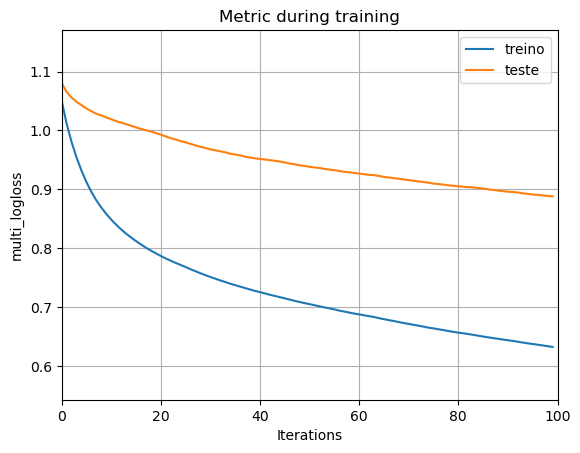

In [23]:
lgb.plot_metric(model_l1)

In [24]:
y_val = df_val['label_l1']
y_pred = model_l1.predict(df_val[model_l1.feature_name_])

In [25]:
precision, recall, fscore, support = precision_recall_fscore_support(
    y_pred=y_pred, y_true=y_val)

In [28]:
resultado = pd.DataFrame(
    {
        'precision': precision,
        'recall': recall,
        'f1score': fscore
    },
    index=['manter', 'comprar', 'vender']
)
resultado

,precision,recall,f1score
manter,0.936746,0.362889,0.523123
comprar,0.145202,0.723270,0.241851
vender,0.150569,0.759574,0.251320


## Selecionando features

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

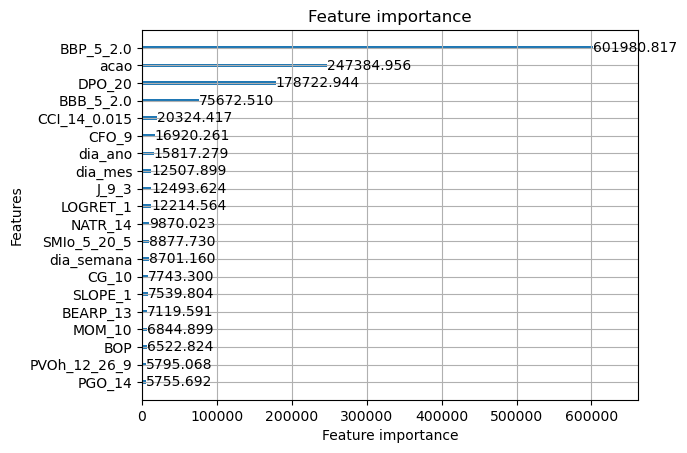

In [29]:
lgb.plot_importance(model_l1, max_num_features=20)

In [30]:
def get_importance(model):
    df_importance = (
        pd.DataFrame(
            {'features': model.feature_name_, 'importance': model.feature_importances_}).sort_values('importance', ascending=False)
    )
    return df_importance

seleciona o numero de features que possuem no mínimo 1 ponto de ganho

In [31]:

features = model_l1.feature_name_
dif = 2

while dif > 0:
    print(len(features))
    model = lgb.LGBMClassifier(importance_type='gain', verbose=0)
    model.fit(
        x_over[features],
        y_over
    )
    df_aux = get_importance(model)
    nova_features = df_aux.loc[df_aux['importance'] > 0, 'features'].to_list()
    dif = len(features)-len(nova_features)

    features = nova_features

115
110
109


In [32]:
len(features)

109

In [33]:
print(features)

['BBP_5_2.0', 'acao', 'DPO_20', 'BBB_5_2.0', 'CCI_14_0.015', 'dia_ano', 'CFO_9', 'dia_mes', 'J_9_3', 'LOGRET_1', 'NATR_14', 'SMIo_5_20_5', 'dia_semana', 'CG_10', 'SLOPE_1', 'BEARP_13', 'MOM_10', 'BOP', 'PVOh_12_26_9', 'PGO_14', 'MASSI_9_25', 'THERMO_20_2_0.5', 'UO_7_14_28', 'ER_10', 'SKEW_30', 'DMP_14', 'PDIST', 'UI_14', 'BULLP_13', 'VHF_28', 'ADX_14', 'PVO_12_26_9', 'CHOP_14_1_100', 'KURT_30', 'STOCHRSIk_14_14_3_3', 'PPOh_12_26_9', 'open_Z_30_1', 'RVI_14', 'AR_26', 'D_9_3', 'EFI_13', 'INERTIA_20_14', 'DMN_14', 'ABER_ATR_5_15', 'CTI_12', 'CMF_20', 'K_9_3', 'PVOs_12_26_9', 'VTXP_14', 'QS_10', 'STOCHRSId_14_14_3_3', 'RSX_14', 'PPO_12_26_9', 'MACDh_12_26_9', 'CMO_14', 'BR_26', 'TRIX_30_9', 'MFI_14', 'KVOs_34_55_13', 'RVGI_14_4', 'STCstoch_10_12_26_0.5', 'ROC_10', 'VAR_30', 'Volume', 'VTXM_14', 'ADOSC_3_10', 'WILLR_14', 'KST_10_15_20_30_10_10_10_15', 'COPC_11_14_10', 'QQE_14_5_4.236', 'PVOL', 'FISHERT_9_1', 'APO_12_26', 'ENTP_10', 'OBV', 'KVO_34_55_13', 'TSIs_13_25_13', 'AROOND_14', 'BIAS_

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

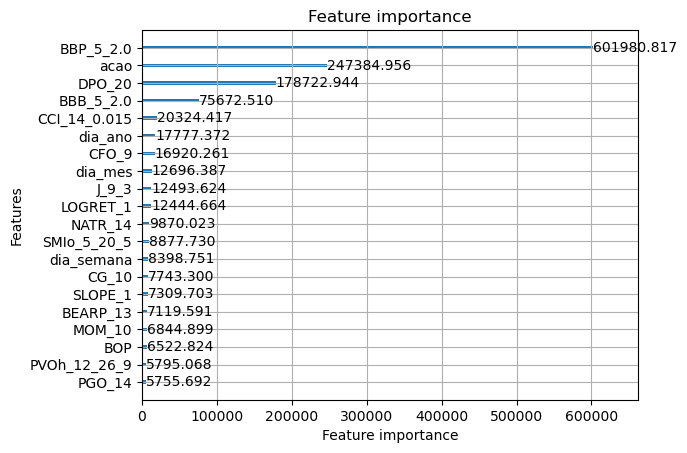

In [34]:
lgb.plot_importance(model, max_num_features=20)

In [35]:
features_select = model.feature_name_
features_select

['BBP_5_2.0',
 'acao',
 'DPO_20',
 'BBB_5_2.0',
 'CCI_14_0.015',
 'dia_ano',
 'CFO_9',
 'dia_mes',
 'J_9_3',
 'LOGRET_1',
 'NATR_14',
 'SMIo_5_20_5',
 'dia_semana',
 'CG_10',
 'SLOPE_1',
 'BEARP_13',
 'MOM_10',
 'BOP',
 'PVOh_12_26_9',
 'PGO_14',
 'MASSI_9_25',
 'THERMO_20_2_0.5',
 'UO_7_14_28',
 'ER_10',
 'SKEW_30',
 'DMP_14',
 'PDIST',
 'UI_14',
 'BULLP_13',
 'VHF_28',
 'ADX_14',
 'PVO_12_26_9',
 'CHOP_14_1_100',
 'KURT_30',
 'STOCHRSIk_14_14_3_3',
 'PPOh_12_26_9',
 'open_Z_30_1',
 'RVI_14',
 'AR_26',
 'D_9_3',
 'EFI_13',
 'INERTIA_20_14',
 'DMN_14',
 'ABER_ATR_5_15',
 'CTI_12',
 'CMF_20',
 'K_9_3',
 'PVOs_12_26_9',
 'VTXP_14',
 'QS_10',
 'STOCHRSId_14_14_3_3',
 'RSX_14',
 'PPO_12_26_9',
 'MACDh_12_26_9',
 'CMO_14',
 'BR_26',
 'TRIX_30_9',
 'MFI_14',
 'KVOs_34_55_13',
 'RVGI_14_4',
 'STCstoch_10_12_26_0.5',
 'ROC_10',
 'VAR_30',
 'Volume',
 'VTXM_14',
 'ADOSC_3_10',
 'WILLR_14',
 'KST_10_15_20_30_10_10_10_15',
 'COPC_11_14_10',
 'QQE_14_5_4.236',
 'PVOL',
 'FISHERT_9_1',
 'APO_12_26'

In [114]:
features_select = [
    'BBP_5_2.0',
    'acao',
    'DPO_20',
    'BBB_5_2.0',
    'CCI_14_0.015',
    'dia_ano',
    'CFO_9',
    'dia_mes',
    'J_9_3',
    'LOGRET_1',
    'NATR_14',
    'SMIo_5_20_5',
    'dia_semana',
    'CG_10',
    'SLOPE_1',
    'BEARP_13',
    'MOM_10',
    'BOP',
    'PVOh_12_26_9',
    'PGO_14',
    'MASSI_9_25',
    'THERMO_20_2_0.5',
    'UO_7_14_28',
    'ER_10',
    'SKEW_30',
    'DMP_14',
    'PDIST',
    'UI_14',
    'BULLP_13',
    'VHF_28',
    'ADX_14',
    'PVO_12_26_9',
    'CHOP_14_1_100',
    'KURT_30',
    'STOCHRSIk_14_14_3_3',
    'PPOh_12_26_9',
    'open_Z_30_1',
    'RVI_14',
    'AR_26',
    'D_9_3',
    'EFI_13',
    'INERTIA_20_14',
    'DMN_14',
    'ABER_ATR_5_15',
    'CTI_12',
    'CMF_20',
    'K_9_3',
    'PVOs_12_26_9',
    'VTXP_14',
    'QS_10',
    'STOCHRSId_14_14_3_3',
    'RSX_14',
    'PPO_12_26_9',
    'MACDh_12_26_9',
    'CMO_14',
    'BR_26',
    'TRIX_30_9',
    'MFI_14',
    'KVOs_34_55_13',
    'RVGI_14_4',
    'STCstoch_10_12_26_0.5',
    'ROC_10',
    'VAR_30',
    'Volume',
    'VTXM_14',
    'ADOSC_3_10',
    'WILLR_14',
    'KST_10_15_20_30_10_10_10_15',
    'COPC_11_14_10',
    'QQE_14_5_4.236',
    'PVOL',
    'FISHERT_9_1',
    'APO_12_26',
    'ENTP_10',
    'OBV',
    'KVO_34_55_13',
    'TSIs_13_25_13',
    'AROOND_14',
    'BIAS_SMA_26',
    'MAD_30',
    'STC_10_12_26_0.5',
    'TOS_STDEVALL_L_2',
    'PSL_12',
    'TOS_STDEVALL_L_1',
    'NVI_1',
    'PVI_1',
    'AROONOSC_14',
    'PSARaf_0.02_0.2',
    'TOS_STDEVALL_L_3',
    'AO_5_34',
    'SQZ_20_2.0_20_1.5',
    'PVT',
    'AD',
    'AROONU_14',
    'Open',
    'PVR',
    'CDL_DOJI_10_0.1',
    'Low',
    'Close',
    'PSARr_0.02_0.2',
    'TTM_TRND_6',
    'SQZ_ON',
    'High',
    'CDL_INSIDE',
    'THERMOs_20_2_0.5',
    'SQZPRO_ON_NARROW',
    'AOBV_LR_2',
    'THERMOl_20_2_0.5',
    'SQZPRO_ON_WIDE'
]

# Otimização

Os melhores hiperparametros foram selecionados usando otimização bayesiana e busca aumentar a precisão para o sinal compra e venda 

In [38]:
def bayes_parameter_opt_lgb(
    X,
    y, init_round=15, opt_round=25, n_folds=3, random_seed=6,
    n_estimators=10000,
    output_process=False
):

    # parameters

    def lgb_eval(
        learning_rate,
        num_leaves,
        feature_fraction,
        bagging_fraction,
        max_depth,
        max_bin,
        bagging_freq,
        min_data_in_leaf,
        min_sum_hessian_in_leaf,
        subsample
    ):
        params = {'importance_type': 'gain'}
        params['learning_rate'] = max(min(learning_rate, 1), 0)
        params["num_leaves"] = int(round(num_leaves))
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params['bagging_freq'] = int(round(bagging_freq))
        params['max_depth'] = int(round(max_depth))
        params['max_bin'] = int(round(max_bin))
        params['min_data_in_leaf'] = int(round(min_data_in_leaf))
        params['min_sum_hessian_in_leaf'] = min_sum_hessian_in_leaf
        params['subsample'] = max(min(subsample, 1), 0)

        model = lgb.LGBMClassifier(verbose=-1, **params)
        model.fit(
            X,
            y
        )
        y_val = df_test['label_l1']
        y_pred = model.predict(df_test[model.feature_name_])
        precision, recall, fscore, support = precision_recall_fscore_support(
            y_pred=y_pred, y_true=y_val)

        result = precision[1]*0.5+precision[2]*0.5

        return result

    lgbBO = BayesianOptimization(lgb_eval, {'learning_rate': (0.001, 0.01),
                                            'num_leaves': (10, 100),
                                            'feature_fraction': (0.1, 1.0),
                                            'bagging_fraction': (0.1, 1.0),
                                            'bagging_freq': (0, 10),
                                            'max_depth': (15, 100),
                                            'max_bin': (20, 90),
                                            'min_data_in_leaf': (10, 100),
                                            'min_sum_hessian_in_leaf': (0, 100),

                                            'subsample': (0.01, 1.0)},
                                 random_state=200)

    # n_iter: How many steps of bayesian optimization you want to perform. The more steps the more likely to find a good maximum you are.
    # init_points: How many steps of random exploration you want to perform. Random exploration can help by diversifying the exploration space.

    lgbBO.maximize(init_points=init_round, n_iter=opt_round)

    model_auc = []
    for model in range(len(lgbBO.res)):
        model_auc.append(lgbBO.res[model]['target'])

    # return best parameters
    return lgbBO.res[pd.Series(model_auc).idxmax()]['target'], lgbBO.res[pd.Series(model_auc).idxmax()]['params']

In [95]:
def pos_processing_opt_byes(
    learning_rate,
    num_leaves,
    feature_fraction,
    bagging_fraction,
    max_depth,
    max_bin,
    bagging_freq,
    min_data_in_leaf,
    min_sum_hessian_in_leaf,
    subsample
):
    params = {'importance_type': 'gain'}
    params['learning_rate'] = max(min(learning_rate, 1), 0)
    params["num_leaves"] = int(round(num_leaves))
    params['feature_fraction'] = max(min(feature_fraction, 1), 0)
    params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
    params['bagging_freq'] = int(round(bagging_freq))
    params['max_depth'] = int(round(max_depth))
    params['max_bin'] = int(round(max_bin))
    params['min_data_in_leaf'] = int(round(min_data_in_leaf))
    params['min_sum_hessian_in_leaf'] = min_sum_hessian_in_leaf
    params['subsample'] = max(min(subsample, 1), 0)

    return params

In [39]:
from bayes_opt import BayesianOptimization

In [40]:
opt_params = bayes_parameter_opt_lgb(
    x_over[features],
    y_over,
    init_round=100,
    opt_round=2,
    n_folds=3,
    random_seed=6,
    n_estimators=10000)

|   iter    |  target   | baggin... | baggin... | featur... | learni... |  max_bin  | max_depth | min_da... | min_su... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------------------
| 1         | 0.1429    | 0.9529    | 2.265     | 0.635     | 0.004855  | 73.49     | 15.24     | 42.17     | 90.97     | 51.05     | 0.982     |
| 2         | 0.1398    | 0.8806    | 9.86      | 0.9309    | 0.003733  | 79.23     | 25.3      | 80.7      | 25.05     | 18.64     | 0.9441    |
| 3         | 0.1448    | 0.8434    | 5.183     | 0.8862    | 0.006205  | 51.51     | 72.81     | 47.75     | 64.04     | 64.78     | 0.1144    |
| 4         | 0.1422    | 0.9694    | 7.587     | 0.7117    | 0.003964  | 21.85     | 83.31     | 97.55     | 28.29     | 68.42     | 0.2729    |
| 5         | 0.1415    | 0.2689    | 4.19      | 0.6994    | 0.005657  | 79.81     | 29.54     | 98.03     | 30.13     | 30

In [41]:
opt_params

(0.1467892476772295,
 {'bagging_fraction': 0.9918038237591607,
  'bagging_freq': 9.619954409342755,
  'feature_fraction': 0.8633640986323939,
  'learning_rate': 0.009944411738680423,
  'max_bin': 81.08435653506316,
  'max_depth': 87.32008200800857,
  'min_data_in_leaf': 96.0220311476426,
  'min_sum_hessian_in_leaf': 10.442793472189027,
  'num_leaves': 96.46381336414088,
  'subsample': 0.7296869986019755})

In [96]:
opt_params = (0.1467892476772295,
              {'bagging_fraction': 0.9918038237591607,
               'bagging_freq': 9.619954409342755,
               'feature_fraction': 0.8633640986323939,
               'learning_rate': 0.009944411738680423,
               'max_bin': 81.08435653506316,
               'max_depth': 87.32008200800857,
               'min_data_in_leaf': 96.0220311476426,
               'min_sum_hessian_in_leaf': 10.442793472189027,
               'num_leaves': 96.46381336414088,
               'subsample': 0.7296869986019755})
best_params = pos_processing_opt_byes(**opt_params[1])

# treinando melhor modelo

In [116]:
model_best = lgb.LGBMClassifier(verbose=-1, **best_params)
model_best.fit(
    x_over[features_select],
    y_over
)
y_val = df_val['label_l1']
y_pred_best = model_best.predict(df_val[model_best.feature_name_])

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

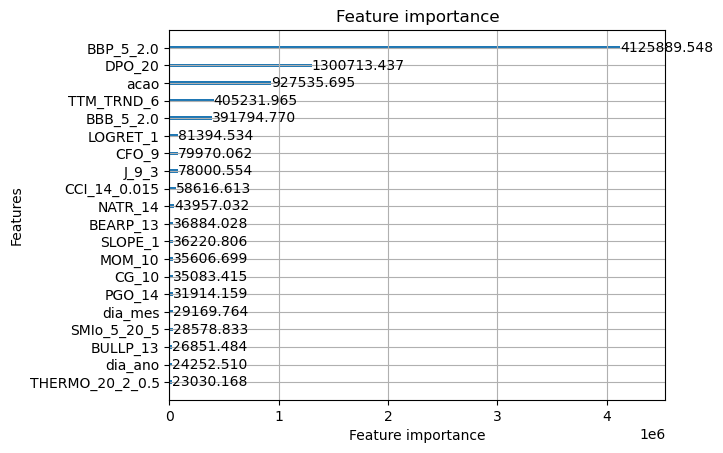

In [117]:
lgb.plot_importance(model_best, max_num_features=20)

In [118]:
importance_features_best = get_importance(model_best)

In [119]:
importance_features_best

,features,importance
0,BBP_5_2.0,4.125890e+06
2,DPO_20,1.300713e+06
1,acao,9.275357e+05
100,TTM_TRND_6,4.052320e+05
3,BBB_5_2.0,3.917948e+05
...,...,...
106,AOBV_LR_2,6.753818e+02
99,PSARr_0.02_0.2,4.422842e+02
108,SQZPRO_ON_WIDE,3.959486e+02
107,THERMOl_20_2_0.5,3.141596e+02


In [120]:
# 35 mais importantes
importance_features_best['features'].iloc[:30].to_list()

['BBP_5_2.0',
 'DPO_20',
 'acao',
 'TTM_TRND_6',
 'BBB_5_2.0',
 'LOGRET_1',
 'CFO_9',
 'J_9_3',
 'CCI_14_0.015',
 'NATR_14',
 'BEARP_13',
 'SLOPE_1',
 'MOM_10',
 'CG_10',
 'PGO_14',
 'dia_mes',
 'SMIo_5_20_5',
 'BULLP_13',
 'dia_ano',
 'THERMO_20_2_0.5',
 'BOP',
 'RVI_14',
 'PVOh_12_26_9',
 'BR_26',
 'PVOs_12_26_9',
 'ER_10',
 'ABER_ATR_5_15',
 'DMP_14',
 'DMN_14',
 'WILLR_14']

In [46]:
precision_best, recall_best, fscore_best, support = precision_recall_fscore_support(
    y_pred=y_pred_best,
    y_true=y_val
)

In [47]:
resultado_best = pd.DataFrame(
    {
        'precision': precision_best,
        'recall': recall_best,
        'f1score': fscore_best
    },
    index=['manter', 'comprar', 'vender']
)
resultado_best

,precision,recall,f1score
manter,0.946919,0.322102,0.480693
comprar,0.139305,0.740042,0.234474
vender,0.149242,0.795745,0.251344


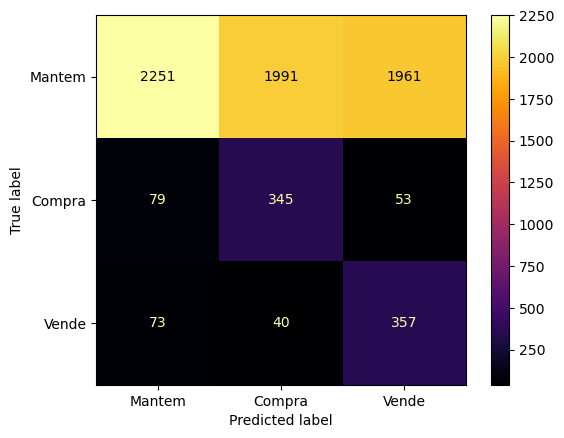

In [48]:
y_pred = model.predict(df_val[model.feature_name_])
cross = pd.crosstab(y_val, y_pred)

matrix = cross.values
cm_display = ConfusionMatrixDisplay(
    confusion_matrix=matrix, display_labels=["Mantem", "Compra", "Vende"])

# display matrix
cm_display.plot(cmap='inferno')

# Backtesting

In [66]:
def test_modelos(acao, df_val=None):
    signais = [i for i in df_val.columns if 'signal' in i]
    df_aux = df_val.loc[
        df_val['acao'] == acao,
        ['Date', 'Close']+signais
    ]

    performances = []

    for sinal in signais:
        bkt_l1 = Backtesting(
            df=df_aux,
            sinal=sinal,
            capital_inicial=1000
        )
        bkt_l1.backtesting()
        performance = round(bkt_l1.capital, 1)
        performances.append(performance)
    return performances, signais

In [69]:
# sinal previsto
df_val['signal_pred'] = y_pred_best

In [71]:
# executando backtesting
acoes = df_test['acao'].unique()
backtest_result = {}
for acao in acoes:
    performance, signais = test_modelos(acao, df_val)
    backtest_result[acao] = performance

In [72]:
df_result = pd.DataFrame(backtest_result, index=[
    signais]).T

In [73]:
df_result.head()

,signal,signal_pred
ABCB4,1188.3,1381.2
ALUP11,1318.8,1134.9
ARZZ3,1679.6,1198.3
B3SA3,1291.4,1077.8
BBAS3,1293.2,1171.8


In [74]:
df_result.describe()

,signal,signal_pred
count,65.000000,65.000000
mean,1433.498462,1225.701538
std,213.933594,132.232113
min,1080.400000,1004.500000
25%,1308.900000,1158.100000
50%,1378.100000,1200.300000
75%,1571.000000,1271.600000
max,2191.300000,1820.900000


In [75]:
(df_result > 1000).sum() / df_result.shape[0]

signal         1.0
signal_pred    1.0
dtype: float64

In [80]:
resultado_best

,precision,recall,f1score
manter,0.946919,0.322102,0.480693
comprar,0.139305,0.740042,0.234474
vender,0.149242,0.795745,0.251344
